In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import patsy as pt
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.decomposition import PCA
import math
import statistics
import matplotlib
from matplotlib import pyplot as plt
matplotlib.style.use('ggplot')

plt.rcParams.update(plt.rcParamsDefault)

In [2]:
def pure_data(filename):

    data = pd.read_csv(filename, sep=',')
    
    added = []
    for index, row in data.iterrows():
        code = row['participant.code']
        subsession = row['subsession.round_number']
        group = row['group.id_in_subsession']
        partner = data[(data['subsession.round_number'] == subsession) & (data['group.id_in_subsession'] == group) & (data['participant.code'] != code)]
        added.append(partner.iloc[0, 7])
        
    data['opponent.decision'] = added
    
    data = data.drop(data[data['subsession.round_number'] > 30].index)
    
    return data

In [3]:
df = pure_data('12.03.21.csv')

In [4]:
def intercount(df, period=None):
    
    if period == None:
        data = df
    else:
        data = df[df['subsession.round_number'] == period]
    
    actions = {}
    actions['AA'] = ['Isolation', 'Isolation', 0]
    actions['AB'] = ['Isolation', 'Suspicion', 0]
    actions['AC'] = ['Isolation', 'Interaction', 0]
    actions['BB'] = ['Suspicion', 'Suspicion', 0.25]
    actions['BC'] = ['Suspicion', 'Interaction', 0.5]
    actions['CC'] = ['Interaction', 'Interaction', 0.75]
    
    for key in actions:
        if actions[key][0] == actions[key][1]:
            num = data[(data['player.decision'] == actions[key][0]) & (data['opponent.decision'] == actions[key][1])].shape[0]
        else:
            num1 = data[(data['player.decision'] == actions[key][0]) & (data['opponent.decision'] == actions[key][1])].shape[0]
            num2 = data[(data['player.decision'] == actions[key][1]) & (data['opponent.decision'] == actions[key][0])].shape[0]
            num = num1 + num2
        actions[key].append(num)
        
    return actions

In [211]:
def avg_risk(dic):
    
    avg_risk = 0
    for key in dic:
        avg_risk += dic[key][2] * dic[key][3]
    
    return avg_risk

In [213]:
print(f'Средний риск взаимодействия в игре:\t{avg_risk(intercount(df))/720: .3f}')

Средний риск взаимодействия в игре:	 0.423


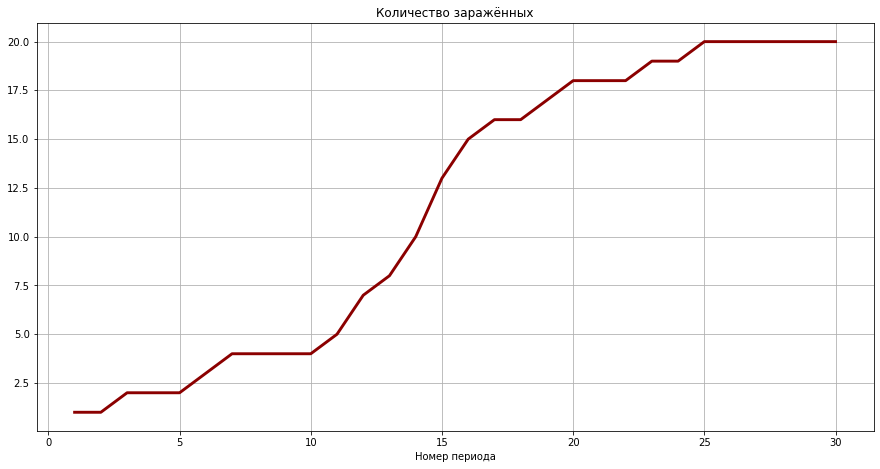

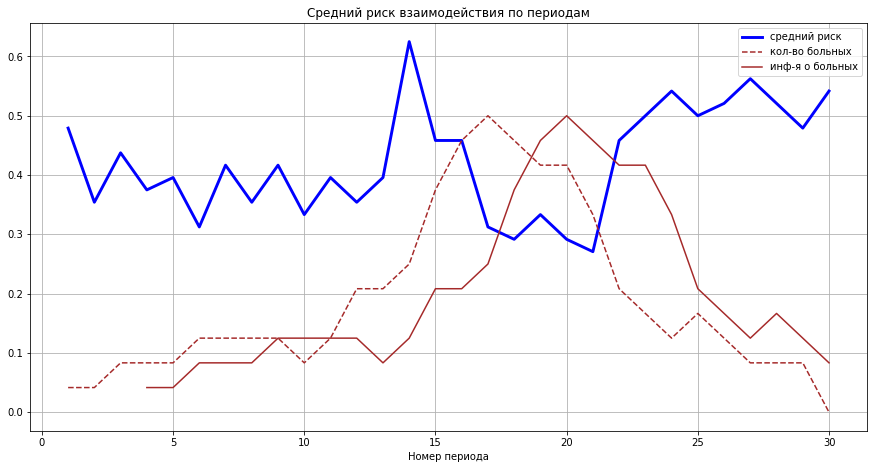

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30
Средний риск,0.48,0.35,0.44,0.38,0.4,0.31,0.42,0.35,0.42,0.33,0.4,0.35,0.4,0.62,0.46,0.46,0.31,0.29,0.33,0.29,0.27,0.46,0.5,0.54,0.5,0.52,0.56,0.52,0.48,0.54


In [272]:
peravg_risk = [avg_risk(intercount(df, x))/24 for x in set(df['subsession.round_number'].iloc[:])]
    
massiv = np.array([[round(x, 2) for x in peravg_risk]])
table = pd.DataFrame(massiv, columns = list(set(df['subsession.round_number'].iloc[:])), index=['Средний риск'])

ill = []
infected = []
for i in np.arange(1, 31):
    subdata = df[df['subsession.round_number'] == i]
    subsubdata = subdata[subdata['player.status'] == 'Ill']
    ill.append(subsubdata.shape[0]/24)
    infected.append(subdata['subsession.total_ill_num_end'].iloc[0])
    
plt.figure(figsize = (15, 7.5))
x = np.arange(1, 31)
plt.plot(x, infected, color = 'darkred', label = 'заражённые', linewidth = 2.9)
plt.title('Количество заражённых')
plt.xlabel('Номер периода')
plt.grid()
   
plt.figure(figsize = (15, 7.5))
x = np.arange(1, 31)
plt.plot(x, np.array(peravg_risk), color = 'blue', label = 'средний риск', linewidth = 2.9)
plt.plot(x, ill, color = 'brown', linestyle = '--', label = 'кол-во больных', linewidth = 1.5)
plt.plot(x[3:], ill[:-3], color = 'brown', label = 'инф-я о больных', linewidth = 1.5)
plt.title('Средний риск взаимодействия по периодам')
plt.xlabel('Номер периода')
plt.legend()
plt.grid()
plt.show()

pd.set_option('display.max_columns', None)
table

На графике отлично видна зависимость поведения общества (синяя кривая) от общей информации о больных (коричневая).
Во-первых, в п.14 случился резкий пик (и максимум за всю игру) среднего взаимодействия игроков. Опираясь и на свои воспоминания от игры, и на логику, предположу, что это вызвано снижением в предыдущем периоде показателя больных с 3 на 2 – люди подумали, что, видимо, сейчас опять вся зараза "затухнет", поэтому можно начинать осторожно зарабатывать очки.
Во-вторых, начиная с п.14 и далее видна обратная зависимость этих двух величин. В то время, как информация о больных имеет форму горба, среднее взаимодействие в группе выгибается к низу.

In [252]:
def deleter(data):
    
    col_titles = ['player#1', 'status#1', 'choice#1', 'player#2', 'status#2', 'choice#2', 'risk', 'period', 'code']   
    for i in np.arange(1, 31):
        subdata = data[data['period'] == i]
        names = []
        newdata = pd.DataFrame([], columns = col_titles)
        
        for index, row in subdata.iterrows():
            if row['player#2'] == 'nan':
                continue
            elif (row['player#1'] in names) & (row['player#1'] != 'nan'):
                continue
            else:
                names.append(row['player#2'])
                newdata = newdata.append(row)
                
        data1 = pd.concat([data[data['period'] != i], newdata], axis=0)
        data = data1
        
    return data

In [259]:
subdata = df[df['subsession.round_number'] < 31]

all_pairs = []

actions = {}
actions['AA'] = ['Isolation', 'Isolation', 0]
actions['AB'] = ['Isolation', 'Suspicion', 0]
actions['AC'] = ['Isolation', 'Interaction', 0]
actions['BB'] = ['Suspicion', 'Suspicion', 0.25]
actions['BC'] = ['Suspicion', 'Interaction', 0.5]
actions['CC'] = ['Interaction', 'Interaction', 0.75]

for index, row in subdata.iterrows():

    code = row['participant.code']
    subsession = row['subsession.round_number']
    group = row['group.id_in_subsession']
    partner = df[(df['subsession.round_number'] == subsession) & (df['group.id_in_subsession'] == group) & (df['participant.code'] != code)]
    
    pair = [row['participant.label'], row['player.status'], row['player.decision']]
    pair.append(partner.iloc[0, 2])
    pair.append(partner.iloc[0, 8])
    pair.append(partner.iloc[0, 7])
    
    action = [row['player.decision'], partner.iloc[0, 7]]
    for key in actions:
        if set(actions[key][0:2]) == set(action):
            pair.append(actions[key][2])
            break
            
    pair.append(int(subsession))
    pair.append(code)
    all_pairs.append(pair)
    
massiv = np.array(all_pairs)
col_titles = ['player#1', 'status#1', 'choice#1', 'player#2', 'status#2', 'choice#2', 'risk', 'period', 'code']
pairs = pd.DataFrame(massiv, columns = col_titles)

pairs['period'] = pd.to_numeric(pairs['period'], errors='coerce')
#pairs = pairs.sort_values('code', ascending=False)[:-int(pairs.shape[0]/2)]
pairs = deleter(pairs)

#pairs1 = pd.concat([pairs, df['subsession.round_number']], axis=1)
#pairs1

In [253]:
ill_dict = {}
for i in np.arange(1, 31):
    ill_dict[i] = int(ill[i-1]*24)

Получена таблица всех взаимодействий игроков. Выберем теперь те из них, в которых был шанс передачи болезни.

In [262]:
pd.set_option('display.max_rows', None)

pairs1 = pairs.drop(['code'], axis=1)
infected_pairs = pairs1[(pairs1['status#1'] == 'Ill') | (pairs1['status#2'] == 'Ill')]
ill_pairs = infected_pairs[(infected_pairs['status#1'] != 'Recovered') & (infected_pairs['status#2'] != 'Recovered')]
risky_pairs = ill_pairs[(ill_pairs['choice#1'] != 'Isolation') & (ill_pairs['choice#2'] != 'Isolation')]
#spread_pairs = risky_pairs[(risky_pairs['status#1'] != 'Ill') | (risky_pairs['status#2'] != 'Ill')]
spread_pairs = risky_pairs

spread_pairs = spread_pairs.sort_values('period')


ill_column = []
for index, row in spread_pairs.iterrows():
    ill_column.append(ill_dict[row['period']])
spread_pairs['ill_number'] = ill_column

spread_pairs

,player#1,status#1,choice#1,player#2,status#2,choice#2,risk,period,ill_number
19,nan,Ill,Interaction,Аминов Тимур,Healthy,Interaction,0.75,1,1
43,nan,Ill,Interaction,Филиппова Валерия Михайловна,Healthy,Suspicion,0.5,2,1
67,nan,Ill,Interaction,Белоконь Леонид,Ill,Suspicion,0.5,3,2
83,Белоконь Леонид,Ill,Suspicion,Денисенко Екатерина Васильевна,Healthy,Suspicion,0.25,4,2
91,nan,Ill,Interaction,Малин Алексей,Healthy,Interaction,0.75,4,2
96,Павлов Никита,Healthy,Interaction,Белоконь Леонид,Ill,Suspicion,0.5,5,2
115,nan,Ill,Interaction,Филиппова Валерия Михайловна,Healthy,Suspicion,0.5,5,2
126,Колягина Вера Николаевна,Healthy,Suspicion,Белоконь Леонид,Ill,Suspicion,0.25,6,3
139,nan,Ill,Interaction,Павлов Никита,Ill,Interaction,0.75,6,3
144,Павлов Никита,Ill,Interaction,Чабан Александр,Healthy,Suspicion,0.5,7,3


In [416]:
spread_pairs.shape[0]

51

Получим теперь таблицу всех взаимодействий, которые реузльтативно сказались на состоянии здоровья игроков.

In [410]:
def past_status1(row):
    
    row = pd.DataFrame(row)
    
    name = row['player#1'].iloc[0]
    period = row['period'].iloc[0]
    status = row['status#1'].iloc[0]
    
    past_row = pairs[(pairs['player#1'] == name) & (pairs['period'] == period - 1)]
    past_st = past_row['status#1']
    
    if past_row.shape[0] == 0:
        past_row = pairs[(pairs['player#2'] == name) & (pairs['period'] == period - 1)]
        past_st = past_row['status#2']
        
    if (name == 'nan') & (status == 'Healthy'):
        return 'Healthy'
    else:
        return past_st.iloc[0]
        
    
    
def past_status2(row):
    
    row = pd.DataFrame(row)
    
    name = row['player#2'].iloc[0]
    period = row['period'].iloc[0]
    status = row['status#2'].iloc[0]
    
    past_row = pairs[(pairs['player#1'] == name) & (pairs['period'] == period - 1)]
    past_st = past_row['status#1']
    
    if past_row.shape[0] == 0:
        past_row = pairs[(pairs['player#2'] == name) & (pairs['period'] == period - 1)]
        past_st = past_row['status#2']
        
    if (name == 'nan') & (status == 'Healthy'):
        return 'Healthy'
    else:
        return past_st.iloc[0]

In [411]:
to_ill = 12*[None]

for i in np.arange(12, 360):
    row = pairs[i:i+1]
    if (row['status#1'].iloc[0] != past_status1(row)) | (row['status#2'].iloc[0] != past_status2(row)):
        to_ill.append(1)
    else:
        to_ill.append(None)

In [415]:
pairs['change'] = to_ill
change_pairs = pairs[pairs['change'] == 1]
change_pairs = change_pairs.drop(['code'], axis=1)

ill_column = []
for index, row in change_pairs.iterrows():
    ill_column.append(ill_dict[row['period']])
change_pairs['ill_number'] = ill_column

change_pairs

,player#1,status#1,choice#1,player#2,status#2,choice#2,risk,period,change,ill_number
67,nan,Ill,Interaction,Белоконь Леонид,Ill,Suspicion,0.5,3,1.0,2
139,nan,Ill,Interaction,Павлов Никита,Ill,Interaction,0.75,6,1.0,3
155,Белоконь Леонид,Ill,Interaction,Шалимов Валентин,Ill,Suspicion,0.5,7,1.0,3
163,nan,Recovered,Interaction,Малин Алексей,Healthy,Suspicion,0.5,7,1.0,3
220,Морозов Анатолий,Healthy,Interaction,Белоконь Леонид,Recovered,Isolation,0,10,1.0,2
240,Павлов Никита,Ill,Interaction,Денисенко Екатерина Васильевна,Ill,Interaction,0.75,11,1.0,3
264,Павлов Никита,Ill,Interaction,Морозов Анатолий,Ill,Interaction,0.75,12,1.0,5
277,Липкин Константин,Ill,Interaction,Денисенко Екатерина Васильевна,Ill,Interaction,0.75,12,1.0,5
288,Павлов Никита,Recovered,Interaction,Белоконь Леонид,Recovered,Interaction,0.75,13,1.0,5
292,Морозов Анатолий,Ill,Interaction,Малин Алексей,Ill,Suspicion,0.5,13,1.0,5


In [413]:
change_pairs.shape[0]

42

Таких оказалось 42, но нужно учесть, что здесь присутствуют и все взаимодействия, на время которых пришёлся момент выздоравления/смерти игроков – тоже изменение состояния здоровья.

По этой таблице легко можно начертить дерево эфолюции болезни по периодам.

In [12]:
def get_letter(action):
    
    if action == 'Isolation':
        return 'A'
    elif action == 'Suspicion':
        return 'B'
    else:
        return 'C'

In [14]:
all_players = []

for i in np.arange(1, 25):
    
    subdata = df[df['participant.id_in_session'] == i]
    player = [subdata.iloc[0, 2]] + [get_letter(x) for x in subdata.iloc[:, 7]]
    player.append(player.count('A'))
    player.append(player.count('B'))
    player.append(player.count('C'))
    player.append(subdata.iloc[0, 3])
    
    all_players.append(player)

col_titles = ['player'] + list(np.arange(1, 31)) + ['#A', '#B', '#C', 'payoff']
players = pd.DataFrame(all_players, columns = col_titles)

Ниже представлена таблица, в которой собраны все действия за 30 периодов для каждого игрока, подсчитаны количества раз, которые каждый игрок выбирал то или иное действие.

In [15]:
players.sort_values('#C', ascending=False)

,player,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,#A,#B,#C,payoff
4,Морозов Анатолий,C,C,C,C,C,C,C,C,C,C,C,C,C,C,C,C,C,C,C,C,C,C,C,C,C,C,C,C,C,C,0,0,30,133
19,NaN,C,C,C,C,C,C,C,C,C,C,C,C,C,C,C,C,C,C,C,C,C,C,C,C,C,C,C,C,C,C,0,0,30,-73
20,Кучеренко Тамара,B,C,C,C,C,C,C,C,C,C,C,C,C,C,C,C,C,B,C,C,C,C,C,C,C,C,C,C,C,C,0,2,28,125
11,Белоконь Леонид,C,C,B,B,B,B,C,A,A,A,C,C,C,C,C,C,C,C,C,C,C,C,C,C,C,C,C,C,C,C,3,4,23,116
21,Шалимов Валентин,C,C,C,C,C,B,B,C,B,B,A,A,A,C,C,C,C,C,C,C,C,C,C,C,C,C,C,C,C,C,3,4,23,-85
16,Денисенко Екатерина Васильевна,A,A,B,B,B,B,C,C,C,B,C,C,C,C,C,C,C,B,C,C,C,C,C,C,C,C,C,C,C,C,2,6,22,112
1,Камалов Ринат,C,C,B,A,A,A,C,C,C,B,B,B,C,C,C,C,B,C,C,C,A,C,C,C,C,C,C,C,C,C,4,5,21,101
22,NaN,C,C,C,C,B,A,C,B,C,C,B,A,C,C,A,B,C,B,C,A,B,B,C,C,C,C,C,C,C,C,4,7,19,103
0,Павлов Никита,C,A,C,C,C,C,C,B,C,A,C,C,C,C,C,C,B,C,B,C,B,B,B,B,B,C,C,B,B,B,2,11,17,-103
14,Кихтенко Андрей,C,C,C,C,C,C,C,C,C,C,B,B,C,C,C,B,B,B,B,B,B,B,B,B,B,B,C,C,C,C,0,13,17,105


Берём периоды с 15 по 21 включая границы и считаем для игрока "средний ход" (А=1, В=2, С=3). Сравниваем с такой же величиной за первые 14 периодов.

Выбраны именно такие границы, потому что наблюдение за разностью поведения игрока именно на этих участках может дать понять, к какой группе его отнести.

Тех, кто Recovered, оцениваем только по действиям до момента выздоровления, либо осознания заболевания. Если неубедительно, то таких всех вообще в отдельную группу.

In [440]:
columns = ['player', '#A', '#B', '#C']
main = players[columns]

round_ill = [x+3 for x in np.array(df[df['subsession.round_number'] == 30]['player.round_ill'])]

main['round_ill'] = round_ill
#main.sort_values('#C', ascending=False)

/Users/Dima/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [505]:
def get_number(letter):
    
    if letter == 'A':
        return 0
    elif letter == 'B':
        return 1
    else:
        return 2


mean1_14 = []
for index, row in players[players.columns[1:15]].iterrows():
    mean1_14.append(round(np.array([get_number(x) for x in row]).mean(), 2))
    
main['avg1-14'] = mean1_14
    

mean15_21 = []
for index, row in players[players.columns[15:22]].iterrows():
    mean15_21.append(round(np.array([get_number(x) for x in row]).mean(), 2))
    
main['avg15-21'] = mean15_21

main.sort_values('#C', ascending=False)

/Users/Dima/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/Users/Dima/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,player,#A,#B,#C,round_ill,avg1-14,avg15-21
4,Морозов Анатолий,0,0,30,15.0,2.00,2.00
19,NaN,0,0,30,3.0,2.00,2.00
20,Кучеренко Тамара,0,2,28,18.0,1.93,1.86
11,Белоконь Леонид,3,4,23,6.0,1.29,2.00
21,Шалимов Валентин,3,4,23,10.0,1.29,2.00
16,Денисенко Екатерина Васильевна,2,6,22,14.0,1.36,1.86
1,Камалов Ринат,4,5,21,17.0,1.29,1.57
22,NaN,4,7,19,22.0,1.50,1.00
0,Павлов Никита,2,11,17,9.0,1.64,1.57
14,Кихтенко Андрей,0,13,17,NaN,1.86,1.14


Отметим каждого игрока на плоскости с координатами x, y равными средним величинам их взаимодействия в два интересующих временных промежутка.

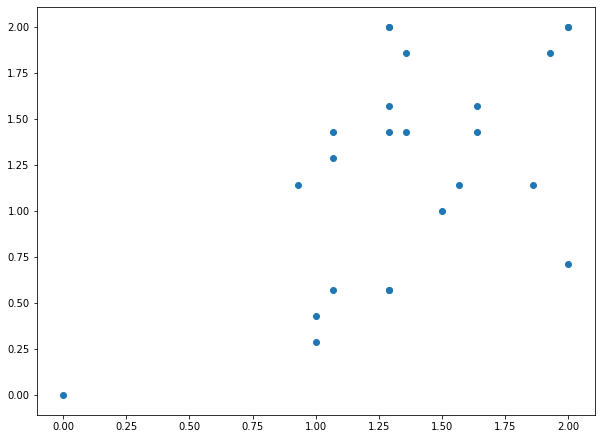

In [459]:
x = main['avg1-14']
y = main['avg15-21']

plt.figure(figsize = (10, 7.5))
plt.scatter(x, y)

Теперь зелёным цветом отметим тех, кто узнал о своей болезни ещё до 15 (для инерции возьмём до 17) периода.

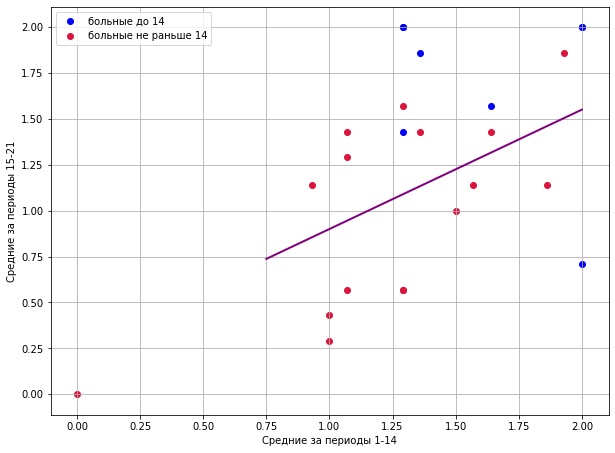

In [504]:
ill1 = main[main['round_ill'] < 17]
ill2 = pd.concat([main, ill1, ill1]).drop_duplicates(keep=False)

plt.figure(figsize = (10, 7.5))
x = ill1['avg1-14']
y = ill1['avg15-21']
plt.scatter(x, y, color = 'blue', label = 'больные до 14')
x = ill2['avg1-14']
y = ill2['avg15-21']
plt.scatter(x, y, color = 'crimson', label = 'больные не раньше 14')
x = np.linspace(0.75, 2, 5)
y = [0.25 + x*0.65 for x in x]
plt.plot(x, y, color = 'purple', linewidth = 2)
plt.xlabel('Средние за периоды 1-14')
plt.ylabel('Средние за периоды 15-21')
plt.legend()
plt.grid()

Руководствуясь визуальным ощущением, я разделил на плоскости точки прямой на две группы.
В первой группе люди реагировали на изменение индикатора больных людей ярче – это демонстрируется тем, что по оси Ох (среднее взаимодействие до 15го периода) их точка лежит ближе к 2, чем по оси Оу (среднее взаимодействие после 15го периода).

In [525]:
group0 = main[main['round_ill'] < 17]
res = pd.concat([main, group0, group0]).drop_duplicates(keep=False)
group1 = main[main['avg15-21'] > 0.25 + 0.65*main['avg1-14']]
group2 = main[main['avg15-21'] <= 0.25 + 0.65*main['avg1-14']]

group_list0 = [str(x) for x in group0['player'].iloc[:]]
group_list1 = [str(x) for x in group1['player'].iloc[:]]
group_list2 = [str(x) for x in group2['player'].iloc[:]]

Построим графики рисков взаимодействий каждой группы игроков по периодам.

In [526]:
def avg_risks(group_list=None):
    
    if group_list == None:
        peravg_risk = [avg_risk(intercount(df, x))/24 for x in set(df['subsession.round_number'].iloc[:])]
    else:
        group = df[df['participant.label'].isin(group_list)]
        peravg_risk = [avg_risk(intercount(group, x))/len(group_list) for x in set(group['subsession.round_number'].iloc[:])]
    
    
    return np.array(peravg_risk)

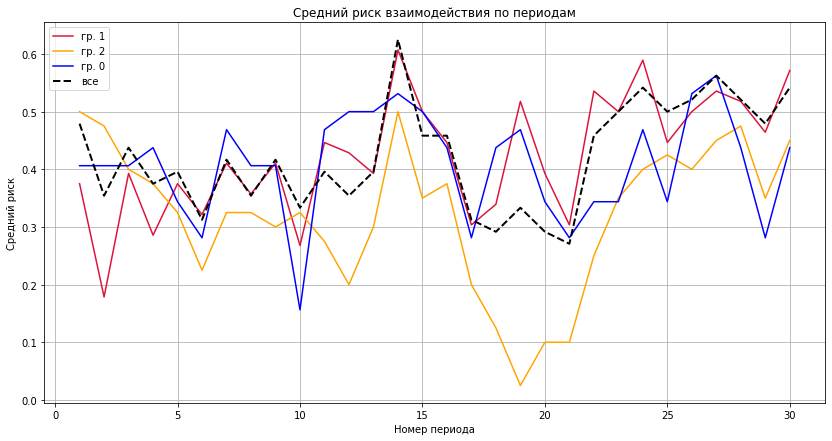

In [528]:
plt.figure(figsize = (14, 7))
x = np.arange(1, 31)
plt.plot(x, avg_risks(group_list1), color = 'crimson', label = 'гр. 1', linewidth = 1.5)
plt.plot(x, avg_risks(group_list2), color = 'orange', label = 'гр. 2', linewidth = 1.5)
plt.plot(x, avg_risks(group_list0), color = 'blue', label = 'гр. 0', linewidth = 1.5)
plt.plot(x, avg_risks(), color = 'black', linestyle = '--', label = 'все', linewidth = 2)

plt.title('Средний риск взаимодействия по периодам')
plt.xlabel('Номер периода')
plt.ylabel('Средний риск')
plt.grid()
plt.legend()
plt.show()

Синим цветом показана динамика среднего риска взаимодействий с участием игроков группы 0 – рано заболевших. Красным и жёлтым – соответственно, гр.1 и гр.2.

Действительно, наблюдается явная разница группы 2 от остальных. В то время, как во время пика заболеваемости игроки группы 2 больше изолировались, игроки групп 0 и 1 не обращали на это особого внимания и продолжали держать уровень риска прежним.

Но, стоит заметить, что хотя линии групп 0 и 1 очень близки во многих характерных областях графика, игроки группы 0 действовали с основанием того, что они уже больны. В то же время игроки группы 1 сами по себе настолько рисковали.

In [529]:
intercount(df)

{'AA': ['Isolation', 'Isolation', 0, 20],
 'AB': ['Isolation', 'Suspicion', 0, 58],
 'AC': ['Isolation', 'Interaction', 0, 106],
 'BB': ['Suspicion', 'Suspicion', 0.25, 86],
 'BC': ['Suspicion', 'Interaction', 0.5, 218],
 'CC': ['Interaction', 'Interaction', 0.75, 232]}

In [530]:
group_list0


['Павлов Никита',
 'Морозов Анатолий',
 'Белоконь Леонид',
 'Липкин Константин',
 'Денисенко Екатерина Васильевна',
 'Малин Алексей',
 'nan',
 'Шалимов Валентин']

In [531]:
group_list1

['Павлов Никита',
 'Камалов Ринат',
 'Морозов Анатолий',
 'Колягина Вера Николаевна',
 'Антонина Тихонова',
 'Белоконь Леонид',
 'Сафина Эльмира',
 'Денисенко Екатерина Васильевна',
 'Тимакова Марина',
 'Малин Алексей',
 'nan',
 'Кучеренко Тамара',
 'Шалимов Валентин',
 'Молчанова Вероника']

In [532]:
group_list2

['Меньшикова Ольга',
 'Чабан Александр',
 'Кравченко Сергей',
 'Галиева Мадина',
 'Негримовский Дмитрий',
 'Филиппова Валерия Михайловна',
 'Липкин Константин',
 'Кихтенко Андрей',
 'Аминов Тимур',
 'nan']